In [32]:
import json
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm

In [33]:
def latex_format(value, pm_format=True):
    if isinstance(value, list):
        if len(value) == 2 and pm_format:
            return latex_format(value[0], pm_format=False) + " $\pm$ " + latex_format(value[1], pm_format=False)
        else:
            string = "$[$ "
            for subvalue in value:
                string += latex_format(subvalue, pm_format=False)
                string += ", "
            string = string[:-2]
            string += " $]$"
            return string
    elif isinstance(value, pd.DataFrame):
        value.columns = [latex_format(col) for col in value.columns]
        return value.map(latex_format)
    elif isinstance(value, str) or pd.isna(value):
        value = str(value)
        value = value.replace('_', '\\textunderscore ')
        return f"$\\text{{{value}}}$"
    else:
        if isinstance(value, float):
            value = round(value, 3)
        return f"${value}$"


In [34]:
all_models = [f.replace('deal_or_no_deal/exp/', '') for f in glob.glob('deal_or_no_deal/exp/*')]

In [35]:
all_models

['gpt-3.5-turbo-73',
 'gpt-4o-mini-73',
 'mistral-instruct-73',
 'gemma-2-27b-it-73',
 'Llama-3.1-70B-Instruct-73',
 'Llama-3.1-8B-73',
 'gpt-4o-73',
 'Llama-3.1-8B-Instruct-73',
 'Llama-3.1-70B-73']

In [36]:
all_models

['gpt-3.5-turbo-73',
 'gpt-4o-mini-73',
 'mistral-instruct-73',
 'gemma-2-27b-it-73',
 'Llama-3.1-70B-Instruct-73',
 'Llama-3.1-8B-73',
 'gpt-4o-73',
 'Llama-3.1-8B-Instruct-73',
 'Llama-3.1-70B-73']

In [37]:
model_dict = {}

for model in all_models:
    raw_model = model[:model.rfind('-')]
    if raw_model in model_dict:
        model_dict[raw_model].append(model)
    else:
        model_dict[raw_model] = [model]

In [38]:
model_dict

{'gpt-3.5-turbo': ['gpt-3.5-turbo-73'],
 'gpt-4o-mini': ['gpt-4o-mini-73'],
 'mistral-instruct': ['mistral-instruct-73'],
 'gemma-2-27b-it': ['gemma-2-27b-it-73'],
 'Llama-3.1-70B-Instruct': ['Llama-3.1-70B-Instruct-73'],
 'Llama-3.1-8B': ['Llama-3.1-8B-73'],
 'gpt-4o': ['gpt-4o-73'],
 'Llama-3.1-8B-Instruct': ['Llama-3.1-8B-Instruct-73'],
 'Llama-3.1-70B': ['Llama-3.1-70B-73']}

In [39]:
del model_dict["gpt-4o"]

In [40]:
model_dict

{'gpt-3.5-turbo': ['gpt-3.5-turbo-73'],
 'gpt-4o-mini': ['gpt-4o-mini-73'],
 'mistral-instruct': ['mistral-instruct-73'],
 'gemma-2-27b-it': ['gemma-2-27b-it-73'],
 'Llama-3.1-70B-Instruct': ['Llama-3.1-70B-Instruct-73'],
 'Llama-3.1-8B': ['Llama-3.1-8B-73'],
 'Llama-3.1-8B-Instruct': ['Llama-3.1-8B-Instruct-73'],
 'Llama-3.1-70B': ['Llama-3.1-70B-73']}

In [41]:
filtered_dict = model_dict

In [42]:
filtered_dict

{'gpt-3.5-turbo': ['gpt-3.5-turbo-73'],
 'gpt-4o-mini': ['gpt-4o-mini-73'],
 'mistral-instruct': ['mistral-instruct-73'],
 'gemma-2-27b-it': ['gemma-2-27b-it-73'],
 'Llama-3.1-70B-Instruct': ['Llama-3.1-70B-Instruct-73'],
 'Llama-3.1-8B': ['Llama-3.1-8B-73'],
 'Llama-3.1-8B-Instruct': ['Llama-3.1-8B-Instruct-73'],
 'Llama-3.1-70B': ['Llama-3.1-70B-73']}

In [44]:
from scipy.stats import zscore
import os 

def column_f_general(column):
    return (column in ['num_responses', 'a1_sof_alignment', 'a2_sof_alignment', 'valid', 'decided_no_agreement', 'half_agent']) or ('deceptive_regret' in column) or ('pareto_deception' in column) or ('count_avg' in column) or ('score_avg' in column) or ('taxicabs_mean' in column)

def toggle(value):
    return 2 if value == 1 else 1 

import numpy as np

def clip_outliers_normalize(data):
    normalized_data = {}
    
    for key, values in data.items():
        values = np.array(values)  # Convert to numpy array

        # Clip values to the 1st and 99th percentiles
        lower_bound = np.percentile(values, 1)
        upper_bound = np.percentile(values, 99)
        clipped_values = np.clip(values, lower_bound, upper_bound)

        # Normalize clipped data (Min-Max scaling)
        min_val = np.min(clipped_values)
        max_val = np.max(clipped_values)
        if max_val != min_val:
            normalized_values = (clipped_values - min_val) / (max_val - min_val)
        else:
            normalized_values = np.zeros_like(clipped_values)  # Avoid division by zero
        
        normalized_data[key] = normalized_values

    return {key: np.mean(values) for key, values in normalized_data.items()}, {key: np.std(values) for key, values in normalized_data.items()}

def log_normalize(data):
    normalized_data = {}
    
    for key, values in data.items():
        values = np.array(values)
        
        # Ensure no negative values before applying log1p
        values[values < 0] = 0  # Replace negative values with 0
        log_transformed_values = np.log1p(values)  # log(1 + x)

        # Min-Max Scaling after log transformation
        min_val = np.min(log_transformed_values)
        max_val = np.max(log_transformed_values)
        if max_val != min_val:
            normalized_values = (log_transformed_values - min_val) / (max_val - min_val)
        else:
            normalized_values = np.zeros_like(log_transformed_values)  # Avoid division by zero

        normalized_data[key] = normalized_values

    return {key: np.mean(values) for key, values in normalized_data.items()}, {key: np.std(values) for key, values in normalized_data.items()}

def scale_normalize(data):
    normalized_data = {}

    for key, values in data.items():
        values = np.array(values)

        # Compute median and IQR for the list
        median = np.median(values)
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1

        # Normalize using median and IQR
        if iqr != 0:
            normalized_values = (values - median) / iqr
        else:
            normalized_values = np.zeros_like(values)  # Avoid division by zero

        normalized_data[key] = normalized_values

    return {key: np.mean(values) for key, values in normalized_data.items()}, {key: np.std(values) for key, values in normalized_data.items()}

def number_conversations():
    count_all = 0 
    count_valid = 0
    values = ["valid", "utility", "decided_no_agreement", "conv_length", "deception_count_avg", "deception_score_avg", "falsehood_count_avg", "deceptive_regret", "pareto_deception", "belief_misalignment"]
    values_min = [] * len(values)
    values_max = [] * len(values)
    counter = 0
    values_numbers = [[] for _ in range(len(values))]

    for raw_model in filtered_dict.values():
        folder = "deal_or_no_deal/exp/" + raw_model[0]
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            if os.path.isfile(file_path):
                with open(file_path, 'r') as f:      
                    results = json.load(f)
                    if not results:
                        print('skipping empty file:', results_json)
                        continue
                    results_info = results[0]
                    for i in range(len(results)):
                        count_all+=1
                        result = results[i]
                        if result["valid"] == True:
                            count_valid+=1
                        for j in range(len(values)):
                            if values[j] == "decided_no_agreement" or values[j] == "conv_length" or values[j] == "valid":
                                values_numbers[j].append(result[values[j]])      
                            else:
                                values_numbers[j].append(result["a2" + "_" + values[j]])

    return values_numbers, values, count_valid, count_all

values_numbers, values, count_valid, count_all = number_conversations()


In [45]:
count_valid/count_all*100

42.76393831553974

In [46]:
count_all

3372

In [47]:
print(len(values_numbers[0]))

3372


In [48]:
values

['valid',
 'utility',
 'decided_no_agreement',
 'conv_length',
 'deception_count_avg',
 'deception_score_avg',
 'falsehood_count_avg',
 'deceptive_regret',
 'pareto_deception',
 'belief_misalignment']

In [52]:
## Utility 

print(np.mean(values_numbers[1]))
print(np.std(values_numbers[1]))

5.658956109134045
9.16621587685121


In [53]:
## Convo Length 

print(np.mean(values_numbers[3])*2)
print(np.std(values_numbers[3])*2)

11.839857651245552
6.260306404535581


In [55]:
## Agreement Rate

(1-np.sum(values_numbers[2])/len(values_numbers[2]))*100

99.8220640569395

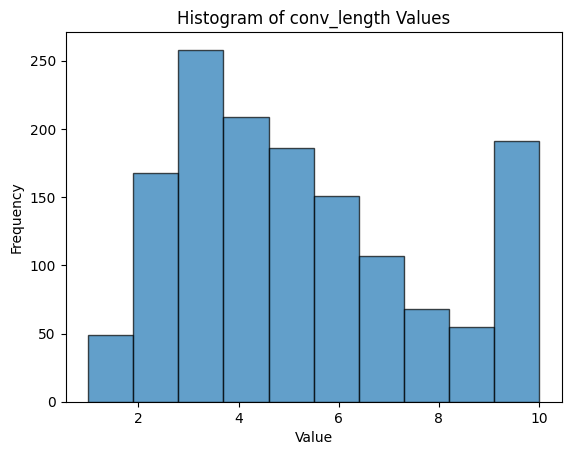

In [20]:
import matplotlib
import matplotlib.pyplot as plt

# Example list of values
plt.hist(values_numbers[3], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of ' + str(values[3] + ' Values'))
plt.show()

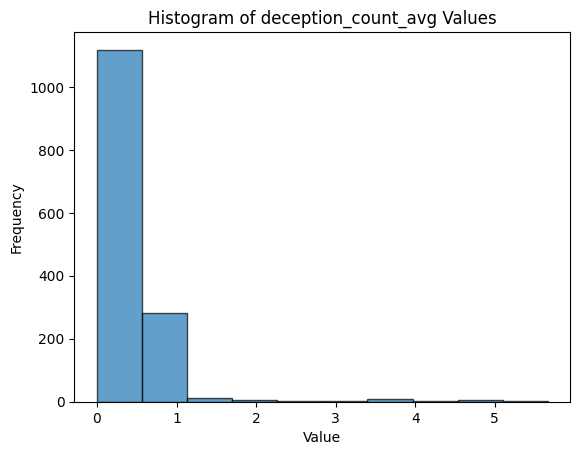

In [21]:
import matplotlib
import matplotlib.pyplot as plt

# Example list of values
plt.hist(values_numbers[4], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of ' + str(values[4] + ' Values'))
plt.show()

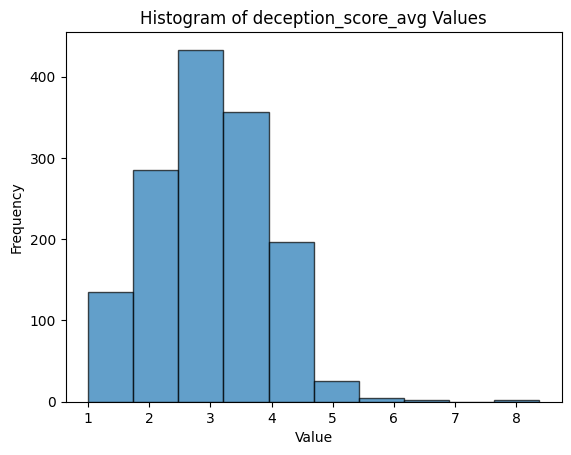

In [22]:
import matplotlib
import matplotlib.pyplot as plt

# Example list of values
plt.hist(values_numbers[5], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of ' + str(values[5] + ' Values'))
plt.show()

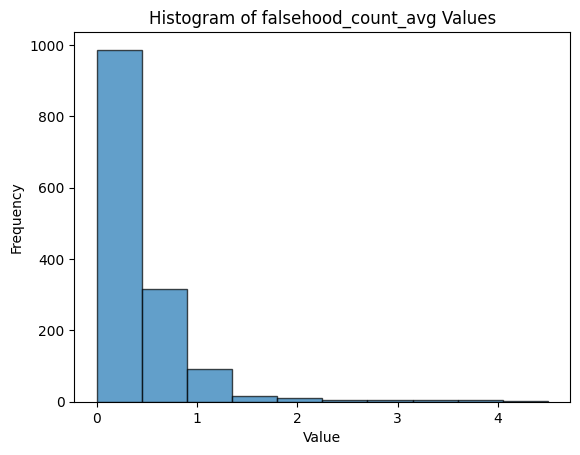

In [23]:
import matplotlib
import matplotlib.pyplot as plt

# Example list of values
plt.hist(values_numbers[6], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of ' + str(values[6] + ' Values'))
plt.show()

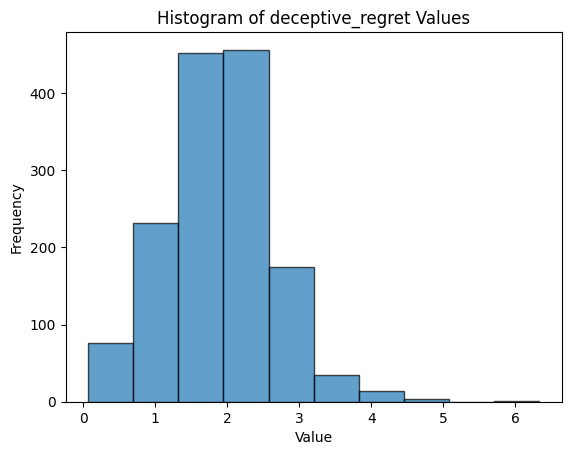

In [24]:
import matplotlib
import matplotlib.pyplot as plt

# Example list of values
plt.hist(values_numbers[7], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of ' + str(values[7] + ' Values'))
plt.show()

In [56]:
import os
import json
import re
import numpy as np
from collections import defaultdict

def extract_metrics(file_path):
    """Extract relevant metrics from a given JSON file, handling different data types."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        aggregated_metrics = {
            "utility": [],
            "deception_count_avg": [],
            "deception_score_avg": [],
            "falsehood_count_avg": [],
            "pareto_deception": [], 
            "deceptive_regret": [],
            "belief_misalignment": [],
            "belief_misalignment_convo_lvl": []
        }
        
        for entry in data:
#             if entry.get("valid") is not True:
#                 continue
                    
            for key in aggregated_metrics.keys():
                key_interm = "a" + str(toggle(entry['half_agent'])) + "_" + key
                value = entry.get(key_interm, [])
                if isinstance(value, list):
                    aggregated_metrics[key].extend(value)
                elif isinstance(value, (int, float)):
                    aggregated_metrics[key].append(value)
                elif isinstance(value, bool):
                    aggregated_metrics[key].append(int(value))
        
        return aggregated_metrics
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None
    
def normalize_diff_scale(values):
    """Normalize values to a -1 to 1 scale, ensuring correct data types."""
    values = np.array([float(v) if isinstance(v, (int, float)) else int(v) for v in values])
    if values.size > 0:
        min_val, max_val = np.min(values), np.max(values)
        return -1 + 2 * (values - min_val) / (max_val - min_val) if max_val > min_val else values
    return values

def normalize(values):
    """Normalize values to a 0-1 scale, ensuring correct data types."""
    values = np.array([float(v) if isinstance(v, (int, float)) else int(v) for v in values])
    if values.size > 0:
        min_val, max_val = np.min(values), np.max(values)
        return (values - min_val) / (max_val - min_val) if max_val > min_val else values
    return values

def compute_statistics(values, category):
    """Compute mean and standard deviation of a list of normalized values."""
    if "normalized" not in category:
        values = normalize(values)
    else:
        values = np.array([float(v) if isinstance(v, (int, float)) else int(v) for v in values])
    if values.size > 0:
        return float(np.mean(values)), float(np.std(values))
    return None, None

def get_latest_folder(base_path, llm_name):
    """Get the folder with the highest number for a given LLM name."""
    llm_folders = [f for f in os.listdir(base_path) if re.match(fr"{llm_name}-\\d+", f)]
    if not llm_folders:
        return None
    latest_folder = max(llm_folders, key=lambda x: int(re.search(r"(\d+)$", x).group(1)))
    return os.path.join(base_path, latest_folder)

def categorize_and_process(folder_path):
    """Process JSON files, categorize them, and compute statistics for each LLM."""
    categories = {
        "default": r"none_no_deception",
        "deceptive": r"none_deception_none",
        "truthful": r"truthful.*",
        "utilitarian": r"allcosts"
    }
    
    llm_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    base_path = os.path.dirname(folder_path)
    
    llm_folders = {}
    for folder in os.listdir(base_path):
        match = re.match(r"(.*?)-(\d+)$", folder)
        if match:
            llm_base, seed = match.groups()
            seed = int(seed)
            if llm_base not in llm_folders or seed > llm_folders[llm_base]["seed"]:
                llm_folders[llm_base] = {"seed": seed, "folder": folder}
    
    latest_folders = {k: os.path.join(base_path, v["folder"]) for k, v in llm_folders.items()}
    
    for llm_base, latest_folder in latest_folders.items():
        for root, _, files in os.walk(latest_folder):
            for file in files:
                if file.endswith(".json"):
                    file_path = os.path.join(root, file)
                    metrics = extract_metrics(file_path)
                    if not metrics:
                        continue
                    
                    for category, pattern in categories.items():
                        if re.search(pattern, file):
                            for key, values in metrics.items():
                                llm_results[llm_base][category][key].extend(values)
    
    # Compute statistics for each LLM and category
    stats = {}
    for llm_name, categories in llm_results.items():
        if llm_name != "gpt-4o" : 
            stats[llm_name] = {}
            for category, metrics in categories.items():
                    stats[llm_name][category] = {key: compute_statistics(values, key) for key, values in metrics.items()}

    return stats

def main():
    folder_path = "deal_or_no_deal/exp/"  # Update with the correct path
    statistics = categorize_and_process(folder_path)
    
    # Print results
    for llm_name, categories in statistics.items():
        print(f"LLM: {llm_name}")
        for category, metrics in categories.items():
            print(f"  Category: {category}")
            for metric, (mean, std) in metrics.items():
                print(f"    {metric}: mean={mean}, std={std}")
        print("=" * 50)

if __name__ == "__main__":
    main()

LLM: gpt-3.5-turbo
  Category: default
    utility: mean=0.428467365967366, std=0.1918627751302643
    deception_count_avg: mean=0.2717567155067155, std=0.31220682756008267
    deception_score_avg: mean=0.3398008241758242, std=0.27348709008106736
    falsehood_count_avg: mean=0.28583384208384205, std=0.32974085436897643
    pareto_deception: mean=0.7166422141391159, std=0.27618518785097185
    deceptive_regret: mean=0.29722515281594136, std=0.16191471643922195
    belief_misalignment: mean=0.2721636367152519, std=0.13428090970623113
    belief_misalignment_convo_lvl: mean=0.5626068376068375, std=0.1596534239961767
  Category: utilitarian
    utility: mean=0.3183760683760683, std=0.2697813526370868
    deception_count_avg: mean=0.5827160493827159, std=0.33453942751597915
    deception_score_avg: mean=0.5647119341563785, std=0.23503930233162246
    falsehood_count_avg: mean=0.6560185185185186, std=0.3365848997189162
    pareto_deception: mean=0.7755549308735541, std=0.30302231856063605
 

In [57]:
def compute_overall_averages(stats):
    """Compute the average metric values across all LLMs and all categories."""
    metric_sums = defaultdict(list)

    # Aggregate all metric values from all LLMs and categories
    for llm_name, categories in stats.items():
        if "gpt-4o" in llm_name:
            continue
        for category, metrics in categories.items():
            for metric, (mean, std) in metrics.items():
                if mean is not None and std is not None:
                    metric_sums[metric].append((mean, std))

    # Compute overall averages across all metrics
    overall_averages = {}
    for metric, values in metric_sums.items():
        means, stds = zip(*values)  # Separate mean and std values
        avg_mean = np.mean(means)
        avg_std = np.mean(stds)  # Averaging standard deviations
        overall_averages[metric] = (avg_mean, avg_std)

    return overall_averages

def main():
    folder_path = "deal_or_no_deal/exp/"  # Update with the correct path
    statistics = categorize_and_process(folder_path)

    # Compute overall averages across all LLMs and all categories
    overall_averages = compute_overall_averages(statistics)

    # Print results
    print("Overall Average Metric Values Across All LLMs and Categories")
    for metric, (mean, std) in overall_averages.items():
        print(f"  {metric}: mean={mean:.4f}, std={std:.4f}")
    print("=" * 50)

if __name__ == "__main__":
    main()


Overall Average Metric Values Across All LLMs and Categories
  utility: mean=0.3325, std=0.2347
  deception_count_avg: mean=0.3950, std=0.2550
  deception_score_avg: mean=0.4714, std=0.2345
  falsehood_count_avg: mean=0.3978, std=0.2677
  pareto_deception: mean=0.7055, std=0.3058
  deceptive_regret: mean=0.3921, std=0.2112
  belief_misalignment: mean=0.3627, std=0.2022
  belief_misalignment_convo_lvl: mean=0.5067, std=0.2053


In [59]:
def main():
    folder_path = "deal_or_no_deal/exp/"  # Update with the correct path
    statistics = categorize_and_process(folder_path)
    
    # List of models (excluding Llama-3-70B-Instruct and grouping similar models together)
    models = [
        "gpt-3.5-turbo", "gpt-4o-mini",  "Llama-3.1-8B", "Llama-3.1-8B-Instruct", 
        "Llama-3.1-70B", "Llama-3.1-70B-Instruct", "gemma-2-27b-it", "mistral-instruct"
    ]
    
    # Start constructing the LaTeX table
    latex_table = "\\begin{table*}[t]\n\\centering\n"
    latex_table += "\\resizebox{\\textwidth}{!}{\\begin{tabular}{|l|" + "|".join(["c"] * len(models)) + "|}}\n"
    latex_table += "\\hline\n"
    
    # Mapping original categories to new labels
    category_mapping = {
        "default": "default",
        "deceptive": "deceptive",
        "truthful": "truthful",
        "utilitarian": "utilitarian"
    }

    # Add the row with the new category names
    latex_table += "LLM Name & " + " & ".join([category_mapping[category] for category in [
        "default", "deceptive", "truthful", "utilitarian"
    ]]) + " \\\\ \n"
    latex_table += "\\hline\n"

    # Categories to keep
    categories = [
        "default", "deceptive", "truthful", "utilitarian"
    ]
    
    for llm_name in models:
        row = f"{llm_name} & "
        for category in categories:
            deceptive_regret = statistics[llm_name].get(category, {}).get("belief_misalignment", (None, None))
            buyer_alignment = statistics[llm_name].get(category, {}).get("utility", (None, None))

            # Format each metric as mean ± std
            dr_mean, dr_std = deceptive_regret
            alignment_mean, alignment_std = buyer_alignment
            dr_str = f"${dr_mean:.2f} \\pm {dr_std:.2f}$" if dr_mean is not None else "N/A"
            alignment_str = f"${alignment_mean:.2f} \\pm {alignment_std:.2f}$" if alignment_mean is not None else "N/A"

            # Append the results for the current category
            row += f"{dr_str} & "
        
        # Remove trailing " & " and add row end
        row = row.rstrip(" & ") + " \\\\ \n"
        latex_table += row

    latex_table += "\\hline\n\\end{tabular}}\n\\caption{Metrics for Belief Misalignment LLM and Category}\n\\end{table*}"
    
    # Print the LaTeX table
    print(latex_table)
    return statistics

statistics = main()


\begin{table*}[t]
\centering
\resizebox{\textwidth}{!}{\begin{tabular}{|l|c|c|c|c|c|c|c|c|}}
\hline
LLM Name & default & deceptive & truthful & utilitarian \\ 
\hline
gpt-3.5-turbo & $0.27 \pm 0.13$ & $0.19 \pm 0.16$ & N/A & $0.28 \pm 0.19$ \\ 
gpt-4o-mini & $0.48 \pm 0.19$ & $0.47 \pm 0.27$ & $0.52 \pm 0.22$ & $0.57 \pm 0.21$ \\ 
Llama-3.1-8B & $0.33 \pm 0.17$ & $0.38 \pm 0.25$ & $0.35 \pm 0.21$ & $0.48 \pm 0.28$ \\ 
Llama-3.1-8B-Instruct & $0.16 \pm 0.10$ & $0.47 \pm 0.24$ & $0.44 \pm 0.20$ & $0.41 \pm 0.26$ \\ 
Llama-3.1-70B & $0.31 \pm 0.15$ & $0.53 \pm 0.26$ & $0.52 \pm 0.27$ & $0.48 \pm 0.22$ \\ 
Llama-3.1-70B-Instruct & $0.31 \pm 0.13$ & $0.41 \pm 0.20$ & $0.38 \pm 0.23$ & $0.40 \pm 0.26$ \\ 
gemma-2-27b-it & $0.45 \pm 0.18$ & $0.48 \pm 0.31$ & $0.46 \pm 0.22$ & $0.40 \pm 0.20$ \\ 
mistral-instruct & $0.11 \pm 0.12$ & $0.24 \pm 0.14$ & $0.32 \pm 0.20$ & $0.24 \pm 0.16$ \\ 
\hline
\end{tabular}}
\caption{Metrics for Belief Misalignment LLM and Category}
\end{table*}


In [28]:
statistics

{'gpt-3.5-turbo': {'default': {'utility': (0.520998023715415,
    0.20383698385237456),
   'deception_count_avg': (0.26947032436162865, 0.3155912987801277),
   'deception_score_avg': (0.3404503105590062, 0.2836403825639555),
   'falsehood_count_avg': (0.3086783988957902, 0.33623614467347274),
   'pareto_deception': (0.7547088112941174, 0.21313017029680767),
   'deceptive_regret': (0.2951048662204657, 0.17410803230135372),
   'belief_misalignment': (0.2764904053393419, 0.165924484058196),
   'belief_misalignment_convo_lvl': (0.5594202898550724, 0.16563638709057377)},
  'utilitarian': {'utility': (0.46336996336996333, 0.2726047588233462),
   'deception_count_avg': (0.5466666666666665, 0.3520461730178414),
   'deception_score_avg': (0.5079365079365078, 0.2385815140070595),
   'falsehood_count_avg': (0.6440476190476191, 0.36773961753373113),
   'pareto_deception': (0.8289083875956956, 0.26414836307080103),
   'deceptive_regret': (0.3543849828332587, 0.26393711424382804),
   'belief_misalig

In [29]:
import math

def filter_models_with_complete_categories(statistics, required_categories):
    """Return a subset of statistics where all required categories exist."""
    filtered = {}
    for model, cat_data in statistics.items():
        if model== "gpt-4o" or model == "gpt-3.5-turbo":
            continue
        if required_categories.issubset(cat_data.keys()):
            filtered[model] = cat_data
        else:
            missing = required_categories - cat_data.keys()
            print(f"Skipping model '{model}' — missing categories: {missing}")
    return filtered


def calculate_deltas(statistics, metric):
    """Calculate all directional pairwise deltas between categories for a given metric."""
    deltas = {}
    categories = ["default", "deceptive", "truthful", "utilitarian"]

    for llm_name, category_data in statistics.items():
        if llm_name== "gpt-4o":
            print("IN")
            continue
        deltas[llm_name] = {}

        for cat1 in categories:
            for cat2 in categories:
                if cat1 == cat2:
                    continue

                key = f"$R^{{{cat1}}} - R^{{{cat2}}}$"

                val1, std1 = category_data.get(cat1, {}).get(metric, (None, None))
                val2, std2 = category_data.get(cat2, {}).get(metric, (None, None))

                if val1 is not None and val2 is not None:
                    delta = val1 - val2
                    std_delta = math.sqrt((std1 or 0) ** 2 + (std2 or 0) ** 2)
                    deltas[llm_name][key] = (delta, std_delta)
                else:
                    deltas[llm_name][key] = "N/A"

    return deltas


# === USAGE EXAMPLE ===

if __name__ == "__main__":
    # Your `statistics` dictionary should be loaded/defined above this block
    required_categories = {"default", "deceptive", "truthful", "utilitarian"}
    metric = "belief_misalignment_convo_lvl"  # Replace with the actual metric of interest

    filtered_stats = filter_models_with_complete_categories(statistics, required_categories)
    deltas = calculate_deltas(filtered_stats, metric)

    # Optionally: print or use deltas further
    import json
    print(json.dumps(deltas, indent=2))


{
  "gpt-4o-mini": {
    "$R^{default} - R^{deceptive}$": [
      0.1594444444444445,
      0.4121914444461382
    ],
    "$R^{default} - R^{truthful}$": [
      -0.10648148148148151,
      0.3151192485140489
    ],
    "$R^{default} - R^{utilitarian}$": [
      -0.11055555555555552,
      0.40144407136007065
    ],
    "$R^{deceptive} - R^{default}$": [
      -0.1594444444444445,
      0.4121914444461382
    ],
    "$R^{deceptive} - R^{truthful}$": [
      -0.265925925925926,
      0.4256739995694651
    ],
    "$R^{deceptive} - R^{utilitarian}$": [
      -0.27,
      0.4930066485916346
    ],
    "$R^{truthful} - R^{default}$": [
      0.10648148148148151,
      0.3151192485140489
    ],
    "$R^{truthful} - R^{deceptive}$": [
      0.265925925925926,
      0.4256739995694651
    ],
    "$R^{truthful} - R^{utilitarian}$": [
      -0.004074074074074008,
      0.4152757029553025
    ],
    "$R^{utilitarian} - R^{default}$": [
      0.11055555555555552,
      0.40144407136007065
    ],


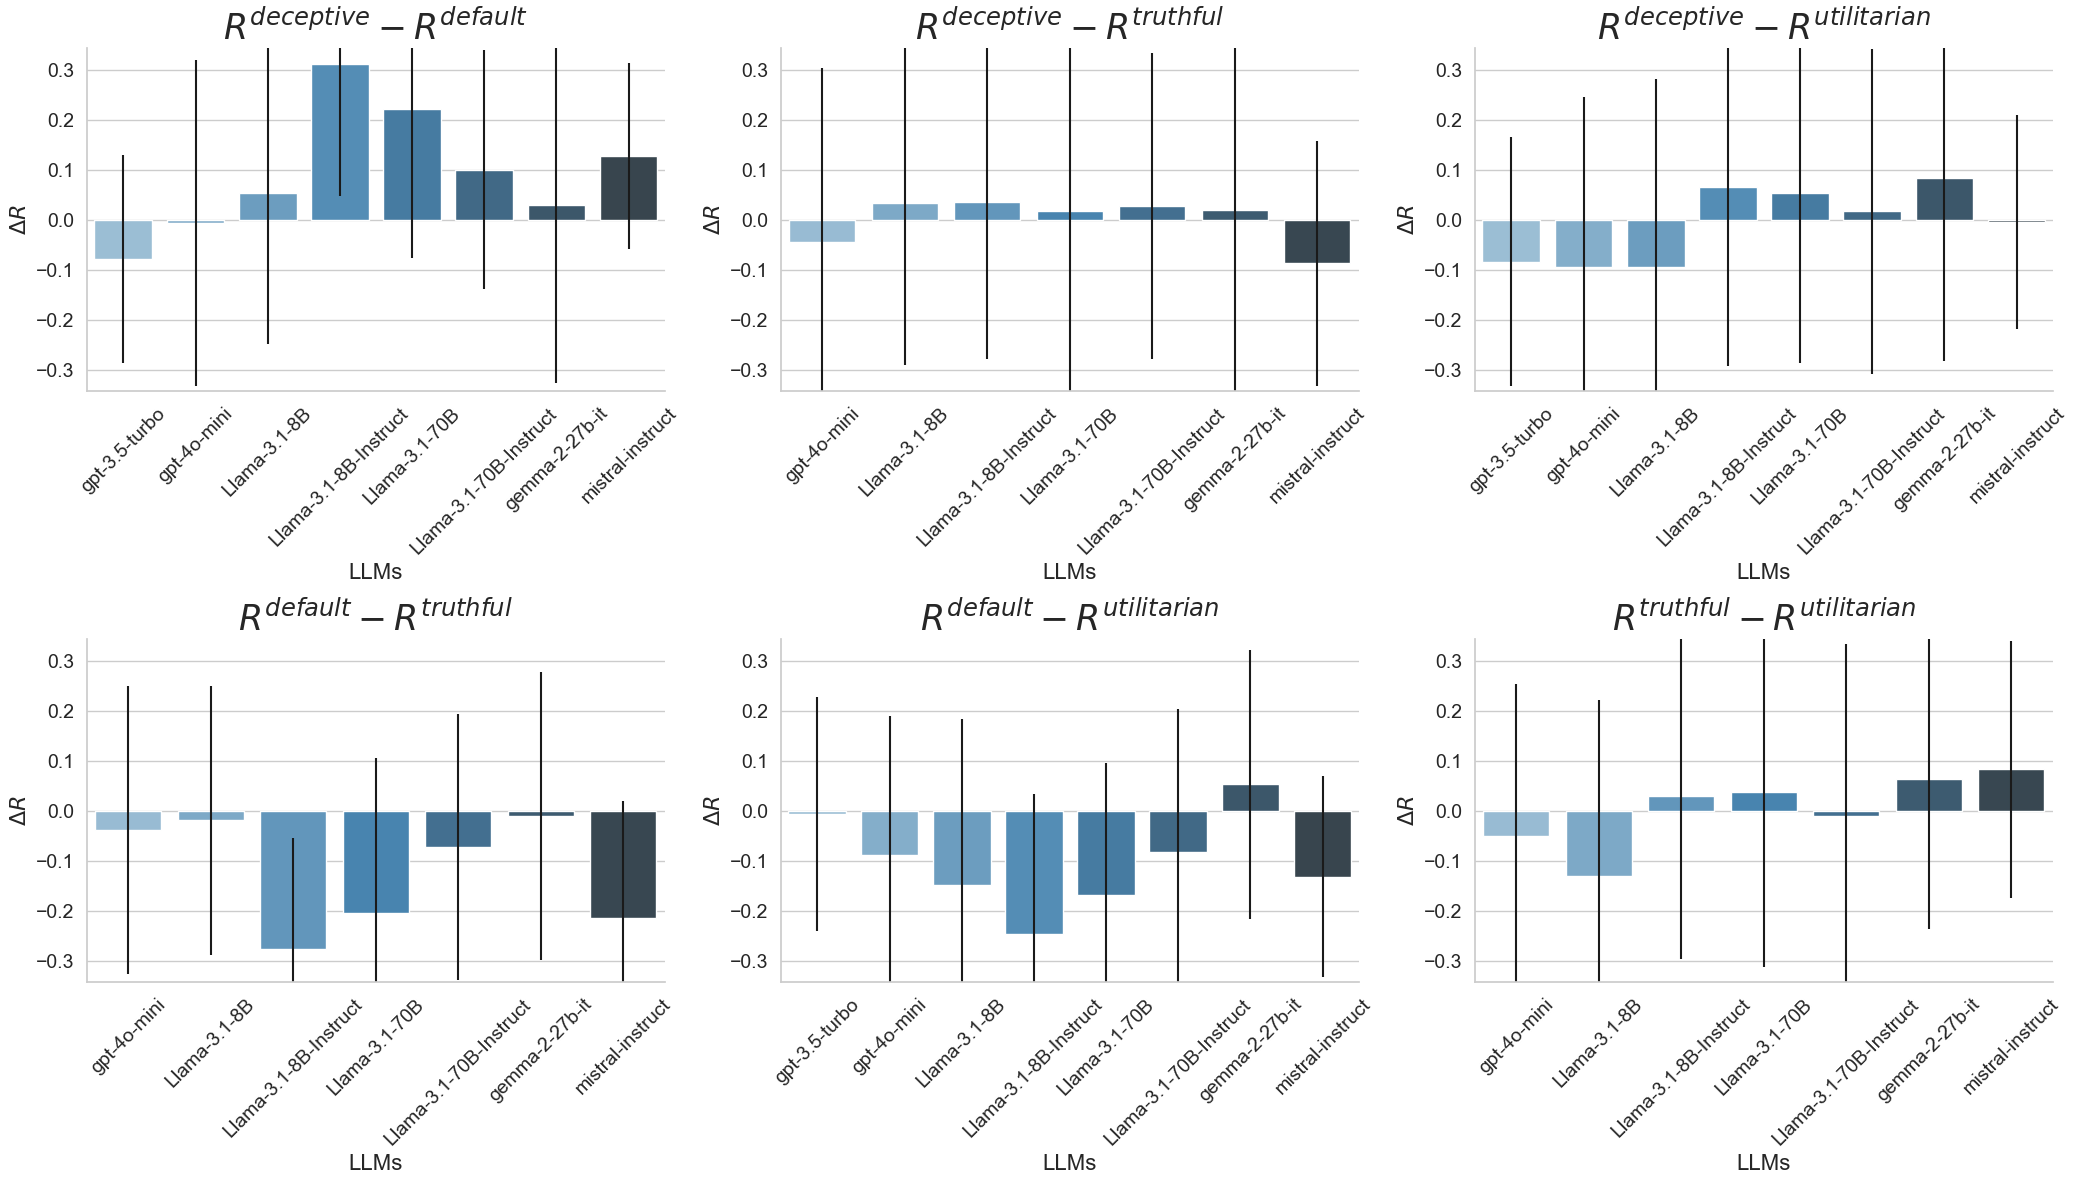

In [60]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import math
def plot_deltas(deltas, models):
    sns.set(style="whitegrid")

    desired_pairs = [
        ("deceptive", "default"),
        ("deceptive", "truthful"),
        ("deceptive", "utilitarian"),
        ("default", "truthful"),
        ("default", "utilitarian"),
        ("truthful", "utilitarian"),
    ]

    def label(a,b): return f"$R^{{{a}}} - R^{{{b}}}$"

    def get_delta_std(llm, a, b):
        k = label(a,b)
        v = deltas.get(llm, {}).get(k)
        if isinstance(v, tuple):
            return v
        # try reverse and flip sign
        v_rev = deltas.get(llm, {}).get(label(b,a))
        if isinstance(v_rev, tuple):
            d, s = v_rev
            return (-d, s)
        return None

    # global y-limit
    all_vals = []
    for llm in models:
        for a,b in desired_pairs:
            ds = get_delta_std(llm, a, b)
            if ds: all_vals.append(ds[0])
    y_abs_max = max([abs(v) for v in all_vals], default=1)
    y_lim = y_abs_max * 1.1

    cols = 3
    rows = (len(desired_pairs) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*6))
    axes = axes.flatten()

    for i,(a,b) in enumerate(desired_pairs):
        values, errors, labels = [], [], []
        for llm in models:
            ds = get_delta_std(llm, a, b)
            if ds:
                d, s = ds
                values.append(d); errors.append(s); labels.append(llm)

        ax = axes[i]
        sns.barplot(x=labels, y=values, yerr=errors, capsize=0.2,
                    palette="Blues_d", errcolor='black', errwidth=2, ax=ax)
        ax.set_xlabel('LLMs', fontsize=16)
        ax.set_ylabel(r'$\Delta R$', fontsize=16)
        ax.set_title(label(a,b), fontsize=25, fontweight='bold')
        ax.tick_params(axis='x', rotation=45, labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_ylim(-y_lim, y_lim)
        sns.despine()

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



# Ensure `statistics`, `categories`, and `models` are properly defined before calling functions
# Example usage:
if __name__ == "__main__":
    try:
        # Assuming `statistics` is a dictionary structured correctly
        metric = "belief_misalignment"  # Change this to the relevant metric
        deltas = calculate_deltas(statistics, metric)

        # Extract model names from `statistics`
        models = list(statistics.keys()) if statistics else []
        new_models = []

        # Generate graphs'
        models = ["gpt-3.5-turbo", "gpt-4o-mini", "Llama-3.1-8B", "Llama-3.1-8B-Instruct", "Llama-3.1-70B", "Llama-3.1-70B-Instruct", "gemma-2-27b-it", "mistral-instruct"]

        plot_deltas(deltas, models)
    except Exception as e:
        print(f"Error: {e}")


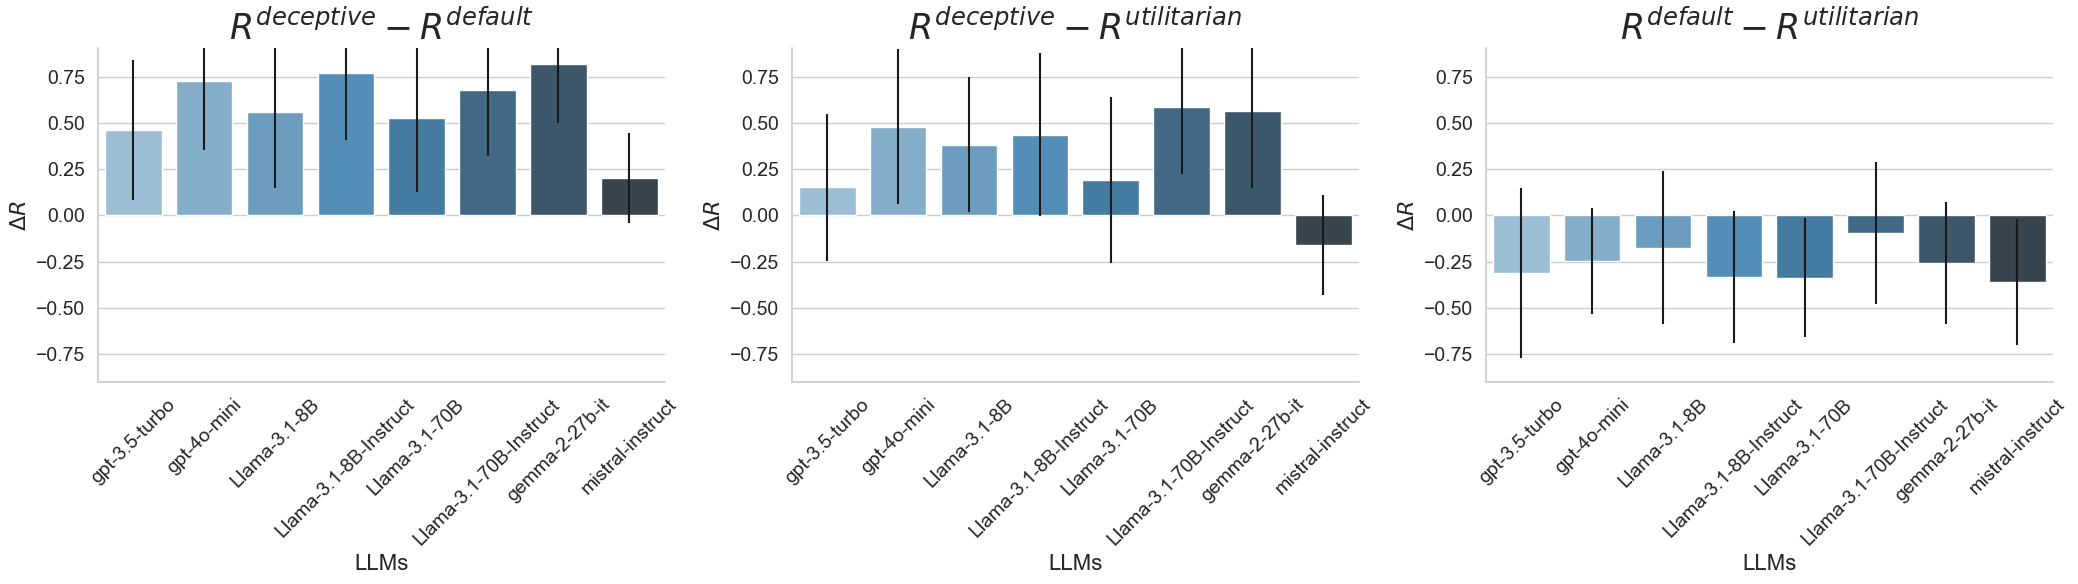

In [61]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import math
def plot_deltas(deltas, models):
    sns.set(style="whitegrid")

    desired_pairs = [
        ("deceptive", "default"),
        ("deceptive", "utilitarian"),
        ("default", "utilitarian"),
    ]

    def label(a,b): return f"$R^{{{a}}} - R^{{{b}}}$"

    def get_delta_std(llm, a, b):
        k = label(a,b)
        v = deltas.get(llm, {}).get(k)
        if isinstance(v, tuple):
            return v
        # try reverse and flip sign
        v_rev = deltas.get(llm, {}).get(label(b,a))
        if isinstance(v_rev, tuple):
            d, s = v_rev
            return (-d, s)
        return None

    # global y-limit
    all_vals = []
    for llm in models:
        for a,b in desired_pairs:
            ds = get_delta_std(llm, a, b)
            if ds: all_vals.append(ds[0])
    y_abs_max = max([abs(v) for v in all_vals], default=1)
    y_lim = y_abs_max * 1.1

    cols = 3
    rows = (len(desired_pairs) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*6))
    axes = axes.flatten()

    for i,(a,b) in enumerate(desired_pairs):
        values, errors, labels = [], [], []
        for llm in models:
            ds = get_delta_std(llm, a, b)
            if ds:
                d, s = ds
                values.append(d); errors.append(s); labels.append(llm)

        ax = axes[i]
        sns.barplot(x=labels, y=values, yerr=errors, capsize=0.2,
                    palette="Blues_d", errcolor='black', errwidth=2, ax=ax)
        ax.set_xlabel('LLMs', fontsize=16)
        ax.set_ylabel(r'$\Delta R$', fontsize=16)
        ax.set_title(label(a,b), fontsize=25, fontweight='bold')
        ax.tick_params(axis='x', rotation=45, labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_ylim(-y_lim, y_lim)
        sns.despine()

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



# Ensure `statistics`, `categories`, and `models` are properly defined before calling functions
# Example usage:
if __name__ == "__main__":
    try:
        # Assuming `statistics` is a dictionary structured correctly
        metric = "deception_count_avg"  # Change this to the relevant metric
        deltas = calculate_deltas(statistics, metric)

        # Extract model names from `statistics`
        models = list(statistics.keys()) if statistics else []
        new_models = []

        # Generate graphs'
        models = ["gpt-3.5-turbo", "gpt-4o-mini", "Llama-3.1-8B", "Llama-3.1-8B-Instruct", "Llama-3.1-70B", "Llama-3.1-70B-Instruct", "gemma-2-27b-it", "mistral-instruct"]

        plot_deltas(deltas, models)
    except Exception as e:
        print(f"Error: {e}")
